# 7. 稀疏机

In [23]:
# preparation
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from prml.kernel import (
    RBF,
    PolynomialKernel,
    SupportVectorClassifier,
    RelevanceVectorRegressor,
    RelevanceVectorClassifier
)

np.random.seed(1234)

在前一章中，我们研究了许多基于非线性核的学习算法。这种算法的一个**最大的局限性是核函数$ k(x_n,x_m) $必须对所有可能的训练点对xn和xm进行求值，这在训练阶段的计算上是不可行的**，且会使得对新的数据点进行预测时也会花费过多的时间。

本章中，我们会看到具有稀疏（sparse）解的基于核的算法，从而对新数据的预测只依赖于在训练数据点的一个子集上计算的核函数。首先，我们详细讨论支持向量机（support vector machine）（SVM），它在一些年之前变得逐渐流行，可以用来解决分类问题、回归问题以及异常点检测问题。支持向量机的一个重要性质是模型参数的确定对应于一个**凸最优化问题**，因此许多局部解也是全局最优解。由于对支持向量机的讨论需要频繁用到拉格朗日乘数法，因此我们建议读者复习附录E中提到的关键的概念。额外的关于支持向量机的介绍，可以参考Vapnik(1995)、Burges(1998)、Cristianini and Shawe-Taylor(2000)、Müller et al.(2001)、Scholkopf and Smola(2002)和Herbrich(2002)。

SVM是一个决策机器，因此**不提供后验概率**。我们已经在1.5.4节讨论过了确定概率的好处。 另一种稀疏核方法，被称为**相关向量机（relevance vector machine）（RVM）**，基于贝叶斯方法，提供了后验概率的输出，并且通常能产生比SVM更稀疏的解。



## 7.1 最大边缘分类器

为了开始我们关于支持向量机的讨论，我们回到使用线性模型的二分类问题。线性模型的形式为
$ y(x) = w^T\phi(x) + b \tag{7.1} $
其中$ \phi(x) $表示一个固定的特征空间变换，并且我们显式地写出了偏置参数$ b $。注意，**我们会简要介绍使用核函数表达的对偶形式，这避免了显式地在特征空间中进行计算**。训练数据集由$ N $个输入向量$ x_1,...,x_N $组成，对应的目标值为$ t_1,...,t_N $，其中$ t_n \in {−1,1} $，新的数据点$ x $根据$ y(x) $的符号进行分类。

现阶段，**我们假设训练数据集在特征空间中是线性可分的**，即根据定义，存在至少一个参数$ w, b $的选择方式，使得对于$ t_n = +1 $的点，函数（7.1）都满足$ y(x_n) > 0 $，对于$ t_n = −1 $的点，都有$ y(x_n) < 0 $，从而对于所有训练数据点，都有$ t_ny(x_n) > 0 $。

当然，存在许多能够把类别精确分开的解。在4.1.7节，我们介绍了**感知器算法**，它能够保证在有限步骤之内找到一个解。然而，它找到的**这个解依赖于$ w, b $的（任意的）初始值选择，还依赖于数据点出现的顺序**。如果有多个能够精确分类训练数据点的解，那么我们应该尝试寻找泛化错误最小的那个解。支持向量机通过**引入边缘(margin)的概念，这 个概念被定义为决策边界与任意样本之间的最小距离来解决这个问题**，如图7.1所示。
 

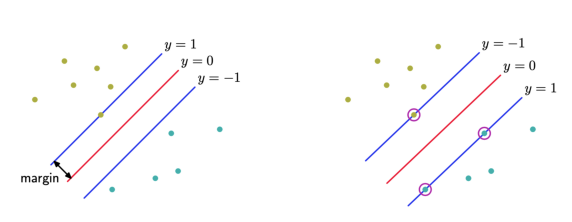

In [7]:
# 图7.1
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图7.1.png')
plt.axis('off')
ax.imshow(d)

图 7.1 边缘被定义为**决策边界与最近的数据点之间的垂直距离**，如左图所示。最大化边缘会生成对决策边界的一个特定的选择，如右图所示。这个决策边界的位置由数据点的**一个子集**确定，被称为支持向量，用圆圈表示。

在支持向量机中，**决策边界被选为使边缘最大化的那个决策边界**。采用最大边缘解的原因可以通过计算学习理论（computational learning theory）或统计学习理论（statistical learning theory）进行理解。然而，Tong and Koller(2000)给出了使用最大边缘解的一个简单的原因。他们考察了一个基于生成式方法和判别式方法组成的金字塔的分类框架，并首先使用带有共同参数$ \sigma^2 $的高斯核的Parzen密度估计对每个类别的输入向量$ x $的分布进行建模。伴随着类别先验，这个分布定义了一个最优的分类错误率决策边界。然而，他们没有使用这个最优的决策边界，而是通过最小化学习到的模型的错误率来寻找最优的超平面。在极限$ \sigma^2 \to 0 $的情况下，**可以证明最优超平面是有着最大边缘的超平面**。这个结果背后的直观含义是，随着$ \sigma^2 $的减小，距离超平面较近的点对超平面的控制能力逐渐大于距离较远的点。在极限情况下，超平面会变得与非支持向量的数据点无关。

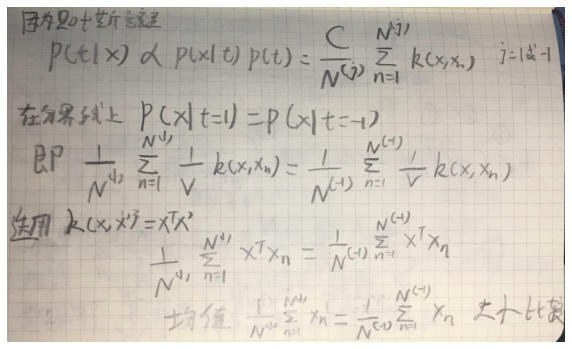

In [3]:
# 7较远无关
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/7较远无关up.png')
plt.axis('off')
ax.imshow(d)

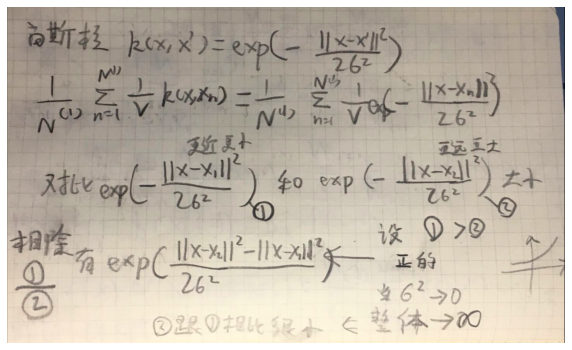

In [4]:
# 7较远无关
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/7较远无关down.png')
plt.axis('off')
ax.imshow(d)

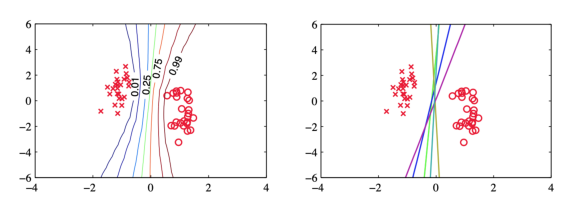

In [8]:
# 图10.13
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图10.13.png')
plt.axis('off')
ax.imshow(d)

我们会在图10.13中看到，对于一个简单的线性可分数据集，在贝叶斯方法中，关于参数的先验概率分布进行积分或求和，可以产生一个位于分开数据点的区域中间的决策边界。最大边缘解有着类似的行为。

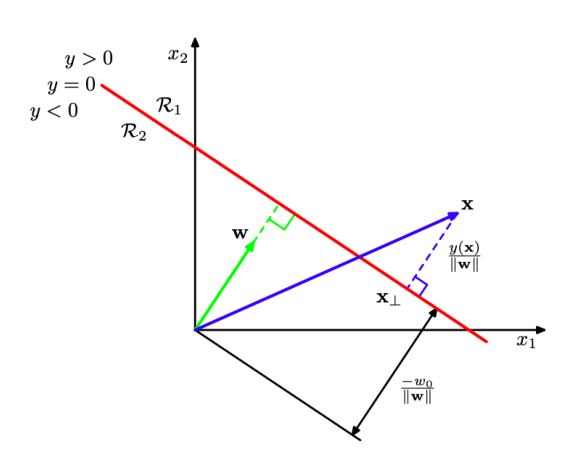

In [9]:
# 图4.1
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图4.1.png')
plt.axis('off')
ax.imshow(d)

回忆一下，根据图4.1，点$ x $与由$ y(x) = 0 $定义的超平面的垂直距离为$ \vert y(x) \vert / \Vert w \Vert $，其中$ y(x) $的形式由式（7.1）给出。此外，我们感兴趣的是那些能够正确分类所有数据点的解，即对于所有的$ n $都有$ t_ny(x_n) > 0 $，因此点$ x_n $距离决策面的距离为
$ \frac{t_ny(x_n)}{\Vert w \Vert} = \frac{t_n(w^T\phi(x_n) + b)}{\Vert w \Vert} \tag{7.2} $
边缘由数据集里垂直距离最近的点$ x_n $给出，我们希望最优化参数$ w,b $，使得这个距离能够最大化。因此，最大边缘解可以通过
$$
\underset{\boldsymbol{w}, b}{\arg \max }\left\{\frac{1}{\|\boldsymbol{w}\|} \min _{n}\left[t_{n}\left(\boldsymbol{w}^{T} \boldsymbol{\phi}\left(\boldsymbol{x}_{n}\right)+b\right)\right]\right\}
\tag{7.3} $$
得到。其中由于$ w, n $无关，所以我们将因子$ 1/\Vert w \Vert $提到了对$ n $的最优化之外。直接求解这个最优化问题相当复杂，因此我们要把它转化为一个更容易求解的等价问题。为了达到这个目的，我们注意到如果我们进行重新缩放$ w \to \kappa w $以及$ b \to \kappa b $，那么任意点$ x_n $距离决策面的距离$ t_ny(x_n) $不会发生改变。我们可以**对距离决策面最近的点**使用这个性质，令
$ t_n(w^T\phi(x_n) + b) = 1 \tag{7.4} $
在这种情况下，所有的数据点会满足限制
$ t(w^T\phi(x_n) + b) \geq 1, n = 1,...,N \tag{7.5} $
这被称为决策超平面的标准表示。对于使上式取得等号的数据点，我们说限制被激活（active），对于其他的数据点，我们说限制未激活（inactive）。根据定义，总会存在至少一个激活限制，因为总会有一个距离最近的点，并且一旦边缘被最大化，会有至少两个激活的限制。这样，最优化问题就简化为了最大化$ \Vert w \Vert^{−1} $，这等价于最小化$ \Vert w \Vert^2 $，因此我们要在限制条件（7.5）下，求解最优化问题
$ \arg\min_{w,b}\frac{1}{2}\Vert w \Vert^2 \tag{7.6} $
式（7.6）的因子$ \frac{1}{2} $的引入是为了后续计算方便。这是二次规划（quadratic programming）问题的一个例子，其中我们试图在一组线性不等式的限制条件下最小化二次函数。**似乎偏置$ b $从最优化问题中消失了。然而，由于这些限制条件要求$ \Vert w \Vert $的改变需要通过$ b $的改变进行补偿，所以它可以通过限制条件隐式地确定。我们稍后会看到它是如何工作的**。


为了解决这个限制的最优化问题，我们引入拉格朗日乘数$ a_n \geq 0 $。式（7.5）中的每个限制条件都对应着一个乘数$ a_n $。从而可得下面的拉格朗日函数
$$
L(\boldsymbol{w}, b, \boldsymbol{a})=\frac{1}{2}\|\boldsymbol{w}\|^{2}-\sum_{n=1}^{N} a_{n}\left\{t_{n}\left(\boldsymbol{w}^{T} \boldsymbol{\phi}\left(\boldsymbol{x}_{n}\right)+b\right)-1\right\}
\tag{7.7} $$
其中$ a = (a_1,...,a_N)^T $。注意，**因为我们要关于$ w, b $最小化，关于$ a $最大化，所以拉格朗日乘数项前面的符号为负**。令$ L(w, b, a) $关于$ w, b $的导数等于0，我们得到了下面两个条件
$ \begin{eqnarray} w &=& \sum\limits_{n=1}^Na_nt_n\phi(x_n) \tag{7.8} \\ 0 &=& \sum\limits_{n=1}^Na_nt_n \tag{7.9} \end{eqnarray} $
使用这两个条件从$ L(w,b,a) $中消去$ w, b $，就得到了最大化边缘问题的对偶表示（dual representation），其中我们要关于$ a $最大化
$ \tilde{L}(a) = \sum\limits_{n=1}^Na_n - \frac{1}{2}\sum\limits_{n=1}^N\sum\limits_{m=1}^Na_na_mt_nt_mk(x_n,x_m) \tag{7.10} $
限制条件为
$ \begin{eqnarray} a_n \geq 0, n=1,...,N \tag{7.11} \\ \sum\limits_{n=1}^Na_nt_n = 0 \tag{7.12} \end{eqnarray} $
这里，核函数被定义为$ k(x, x') = \phi(x)^T\phi(x') $。同样的，这是一个二次规划问题，其中我们要在不等式限制条件下最优化$ a $的**二次函数**。我们会在7.1.1节讨论求解这种二次规划问题的方法。

$ M $个变量的二次规划问题的求解，通常的时间复杂度为$ O(M^3) $。通过将原始问题转化为对偶问题，我们将涉及到$ M $个变量的最小化公式（7.6）的问题转化为了涉及到$ N $个变量的对偶问题（7.10）。对于一组固定的基函数，其中基函数的数量$ M $小于数据点的数量$ N $，转化为对偶问题似乎没有什么好处。但是，对偶问题使得模型能够用核函数重新表示，**因此最大边缘分类器可以被高效地应用于维数超过数据点个数的特征空间**，包括无穷维特征空间。**核公式也让核函数$ k(x, x') $正定这一限制条件存在的原因变得更显然，因为这确保了拉格朗日函数$ \tilde{L}(a) $有上界，从而使得最优化问题有良好的定义**。

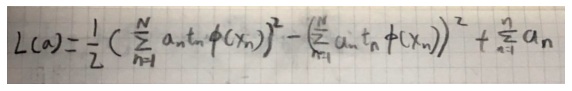

In [5]:
# 推导 7.10
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/推导7.10.png')
plt.axis('off')
ax.imshow(d)



为了使用训练过的模型**分类新的数据点**，我们计算式（7.1）定义的$ y(x) $的符号。通过使用式（7.8）消去$ w $，$ y(x) $可以根据参数$ {a_n} $和核函数表示，即
$ y(x) = \sum\limits_{n=1}^Na_nt_nk(x,x_n) + b \tag{7.13} $
在附录E中，我们说明了这种形式的限制的最优化问题满足Karush-Kuhn-Tucker（KKT）条件。在这个问题中具有
$ \begin{eqnarray} a_n &\geq& 0 \tag{7.14} \\ t_ny(x_n) - 1 &\geq& 0 \tag{7.15} \\ a_n\{t_ny(x_n) - 1\} &=& 0 \tag{7.16} \end{eqnarray} $
这三个性质。因此对于每个数据点，要么$ a_n = 0 $，要么$ t_ny(x_n) = 1 $。任何使得$ a_n = 0 $的数据点都不会出现在式（7.13）的求和式中，因此对新数据点的预测没有作用。剩下的数据点被称为**支持向量（support vector）**。由于这些支持向量满足$ t_ny(x_n) = 1 $，因此它们对应于特征空间中位于最大边缘超平面内的点，如图7.1所示。

这个性质是支持向量机在实际应用中的核心。一旦模型被训练完毕，相当多的数据点都可以被丢弃，只有支持向量被保留。



解决了二次规划问题，找到了$ a $的值之后，注意到支持向量$ x_n $满足$ t_ny(x_n) = 1 $，我们就可以确定阈值参数$ b $的值。使用式（7.13）得到：
$ t_n\left(\sum\limits_{m \in S}a_mt_mk(x_n,x_m) + b\right) = 1 \tag{7.17} $
其中$ S $表示支持向量的下标集合。虽然我们可以使用任意选择的支持向量$ x_n $解这个关于$ b $的方程，但是我们可以通过，首先乘以$ t_n $，使用$ t_n^2 = 1 $的性质，然后对于所有的支持向量，整理方程，解出$ b $得到
$ b = \frac{1}{N_S}\sum\limits_{n \in S}\left(t_n - \sum\limits_{m \in S}a_mt_mk(x_n,x_m)\right) \tag{7.18} $
**其中$ N_S $是支持向量的总数**，来得到在数值计算上更加稳定的解。

对于接下来的模型比较，我们可以将最大边缘分类器通过带有简单二次正则化项的**最小化误差函数来表示**，形式为：
$ \sum\limits_{n=1}^NE_{\infty}(y(x_n)t_n - 1) + \lambda\Vert w \Vert^2 \tag{7.19} $
其中$ E_{\infty}(z) $是一个函数，当$ z \geq 0 $时，函数值为零，其他情况下函数值为$ \infty $。这就确保了限制条件（7.5）成立。注意，只要正则化参数满足$ \lambda > 0 $，那么它的精确值就没有影响。
图7.2给出了一个分类问题的例子。

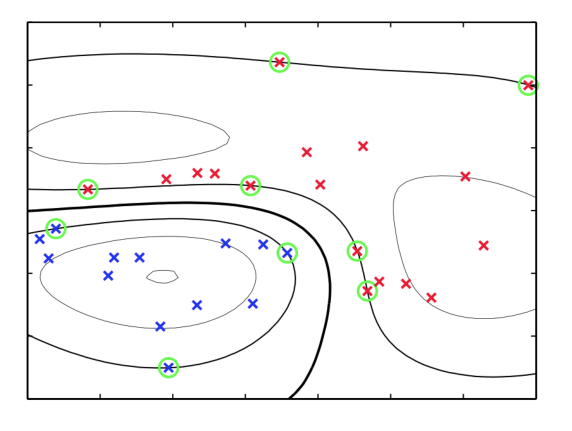

In [10]:
# 图7.2
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图7.2.png')
plt.axis('off')
ax.imshow(d)

 图 7.2 二维空间中来自两个类别的人工生成数据的例子。图中画出了具有高斯核函数的支持向量机的得到的常数$ y(x) $的轮廓线。同时给出的时决策边界、边缘边界以及支持向量。
 
分类用的模型使用支持向量机训练，训练数据是一个简单的人工生成的数据集，核函数是式（6.23）给出的高斯核。虽然数据点在二维空间中显然不是线性可分的，但是它在隐式地由非线性核函数定义的非线性特征空间中是线性可分的。因 此，训练数据点在原始数据空间中被完美地分开了。

这个例子也从几何角度说明了SVM中**稀疏性的来源**。最大边缘超平面由支持向量的位置定义，其他数据点可以自由移动（只要仍然在边缘区域之外）而不改变决策边界，因此解与这些数据点无关。



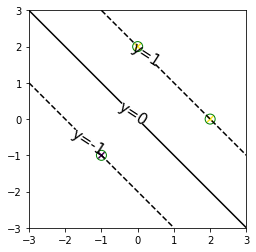

In [2]:
# 例子
x_train = np.array([
        [0., 2.],
        [2., 0.],
        [-1., -1.]])
y_train = np.array([1., 1., -1.])

model = SupportVectorClassifier(PolynomialKernel(degree=1))
model.fit(x_train, y_train)
x0, x1 = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
x = np.array([x0, x1]).reshape(2, -1).T
plt.scatter(x_train[:, 0], x_train[:, 1], s=40, c=y_train, marker="x")
plt.scatter(model.X[:, 0], model.X[:, 1], s=100, facecolor="none", edgecolor="g")
cp = plt.contour(x0, x1, model.distance(x).reshape(100, 100), np.array([-1, 0, 1]), colors="k", linestyles=("dashed", "solid", "dashed"))
plt.clabel(cp, fmt='y=%.f', inline=True, fontsize=15)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.gca().set_aspect("equal", adjustable="box")

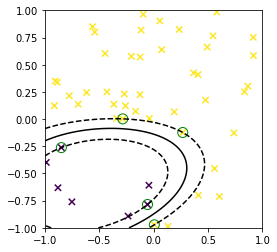

In [3]:
# 例子
def create_toy_data():
    x = np.random.uniform(-1, 1, 100).reshape(-1, 2)
    y = x < 0
    y = (y[:, 0] * y[:, 1]).astype(np.float)
    return x, 1 - 2 * y

x_train, y_train = create_toy_data()

model = SupportVectorClassifier(RBF(np.ones(3)))
model.fit(x_train, y_train)

x0, x1 = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
x = np.array([x0, x1]).reshape(2, -1).T
plt.scatter(x_train[:, 0], x_train[:, 1], s=40, c=y_train, marker="x")
plt.scatter(model.X[:, 0], model.X[:, 1], s=100, facecolor="none", edgecolor="g")
plt.contour(
    x0, x1, model.distance(x).reshape(100, 100),
    np.arange(-1, 2), colors="k", linestyles=("dashed", "solid", "dashed"))
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect("equal", adjustable="box")

参考资料：
- https://cloud.tencent.com/developer/article/1503367
- https://www.slideshare.net/thorikawa/prml-chapter7
- https://www.slideshare.net/matsuolab/prml7-78266098

## 7.1.1 重叠类分布

目前为止，我们假设训练数据点在特征空间$ \phi(x) $中是线性可分的。解得的支持向量机在原始输入空间$ x $中会对训练数据进行精确地划分，虽然对应的决策边界是非线性的。然而，在实际中，类条件分布**可能重叠**，这种情况下对训练数据的精确划分会导致较差的泛化能力。

$ \sum\limits_{n=1}^NE_{\infty}(y(x_n)t_n - 1) + \lambda\Vert w \Vert^2 \tag{7.19} $

因此我们需要一种方式修改支持向量机，**允许一些训练数据点被误分类**。根据式（7.19），我们看到在可以分开的类别的情况下，我们隐式地使用了一个误差函数。当数据点被错误分类时，这个误差函数等于无穷大，而当数据点被正确分类时，这个误差函数等于零，这样就将模型参数优化为了最大化边缘。我们现在修改这种方法，使得数据点允许在边缘边界的“错误侧”，但是增加一个惩罚项，**这个惩罚项随着与决策边界的距离的增大而增大**。对于接下来的最优化问题，令这个惩罚项是距离的线性函数比较方便。为了完成这一点，我们引入松弛变量（slack variable）$ \xi_n \geq 0 $，其中$ n = 1,...,N $，每个训练数据点都有一个**松弛变量**（Bennett, 1992; Cortes and Vapnik, 1995）。对于位于正确的边缘边界内部的点或边界上的点，$ \xi_n = 0 $，对于其它点$ \xi_n = \vert t_n − y(x_n) \vert $。因此,对于位于决策边界$ y(x_n) = 0 $上的点，$ \xi_n = 1 $，且$ \xi_n > 1 $的点就是被误分类的点。这样，式（7.5）给出的精确分类的限制条件就被替换为
$ t_ny(x_n) \geq 1 - \xi_n, n=1,...,N \tag{7.20} $
其中松弛变量被限制为满足$ \xi_n \geq 0 $。$ \xi_n = 0 $的数据点被正确分类，要么位于边缘上，要么在边缘的正确一侧。$ 0 < \xi_n \leq 1 $的点位于边缘内部，但是在决策边界的正确一侧。$ \xi_n > 1 $的点位于决策边界的错误一侧，是被错误分类的点。如图7.3所示。

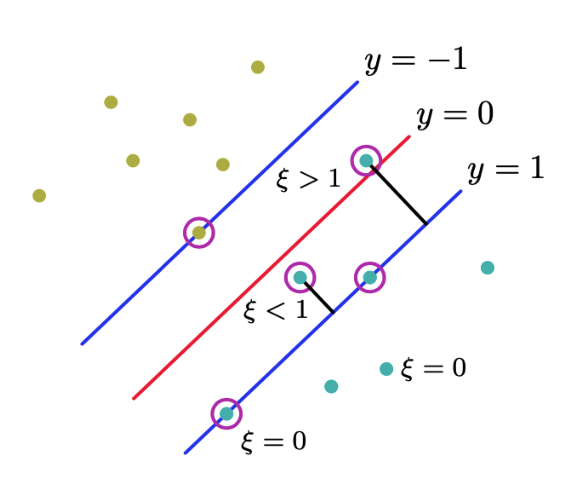

In [20]:
# 图7.3
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图7.3.png')
plt.axis('off')
ax.imshow(d)

图 7.3 松弛变量$ \xi_n \geq 0 $的说明。圆圈标记的数据点是支持向量。

**这种方法有时被描述成放宽边缘的硬限制，得到一个软边缘（soft margin）**，并且允许一些训练数据点被错分。注意，虽然松弛变量允许类分布的重叠，但是这个框架对于异常点很敏感，因为误分类的惩罚随着$ \xi $线性增加。

现在我们的目标是最大化边缘，同时以一种比较柔和的方式惩罚位于边缘边界错误一侧的点。于是，我们最小化
$ C\sum\limits_{n=1}^N\xi_n + \frac{1}{2}\Vert w \Vert^2 \tag{7.21} $
其中参数$ C > 0 $控制了松弛变量惩罚与边缘之间的折中。由于任何被误分类的数据点都有$ \xi_n > 1 $，因此$ \sum_n\xi_n $是误分类数据点数量的上界。于是，参数$ C $类似于（作用相反的）正则化系数，因为它控制了最小化训练误差与模型复杂度之间的折中。在$ C \to \infty $的期限情况下，我们就回到了之前讨论过的用于线性可分数据的支持向量机。

我们现在想要在式（7.20）以及$ \xi_n \geq 0 $的条件下最小化公式（7.21）。对应的拉格朗日函数为：
$ L(w,b,\xi,a,\mu) = \frac{1}{2}\Vert w \Vert^2 + C\sum\limits_{n=1}^N\xi_n - \sum\limits_{n=1}^Na_n{t_ny(x_n) - 1 + \xi_n} - \sum\limits_{n=1}^N\mu_n\xi_n \tag{7.22} $
其中$ {a_n \geq 0} $和$ {\mu_n \geq 0} $是拉格朗日乘数。对应的KKT条件为
$ \begin{eqnarray} a_n &\geq& 0 \tag{7.23} \\ t_ny(x_n) - 1 + \xi_n &\geq& 0 \tag{7.24} \\ a_n(t_ny(x_n) - 1 + \xi_n) &=& 0 \tag{7.25} \\ \mu_n &\geq& 0 \tag{7.26} \\ \xi_n &\geq& 0 \tag{7.27} \\ \mu_n\xi_n &=& 0 \tag{7.28} \end{eqnarray} $
其中$ n = 1,...,N $。

我们现在对$ w, b $和$ {\xi_n} $进行最优化。使用式（7.1）给出的$ y(x) $的定义，我们有
$ \begin{eqnarray} \frac{\partial L}{\partial w} = 0 &\rightarrow& w = \sum\limits_{n=1}^Na_nt_n\phi(x_n) \tag{7.29} \\ \frac{\partial L}{\partial b} = 0 &\rightarrow& \sum\limits_{n=1}^Na_nt_n = 0 \tag{7.30} \\ \frac{\partial L}{\partial \xi_n} = 0 &\rightarrow& a_n = C - \mu_n \tag{7.31} \end{eqnarray} $
使用这些结果，从拉格朗日函数中消去$ w, b, {\xi_n} $，我们得到形式为
$ \tilde{L}(a) = \sum\limits_{n=1}^Na_n - \frac{1}{2}\sum\limits_{n=1}^N\sum\limits_{m=1}^Na_na_mt_nt_mk(x_n,x_m) \tag{7.32} $
的拉格朗日函数。

这与线性可分的情况完全相同，唯一的区别就是限制条件多少有些差异。为了理解这些限制条件究竟是什么，我们注意到，由于$ a_n $是拉格朗日乘数，因此必须有$ a_n \geq 0 $。此外，式（7.31）以及$ \mu_n \geq 0 $表明$ a_n \leq C $。于是，我们关于对偶变量$ {a_n} $最大化式（7.32）时必须要满足
$ \begin{eqnarray} 0 \leq a_n \leq C \tag{7.33} \\ \sum\limits_{n=1}^Na_nt_n = 0 \tag{7.34} \end{eqnarray} $
的限制。其中$ n = 1,...,N $。式（7.33）被称为盒限制（box constraint）。这又一次变成了一个二次规划的问题。如果我们将式（7.29）代入式（7.1），我们看到对于新数据点的预测又一次使用了式（7.13）。

$ y(x) = \sum\limits_{n=1}^Na_nt_nk(x,x_n) + b \tag{7.13} $

我们现在可以表示最终的解。同样的，对于数据点的一个子集，有$ a_n = 0 $，在这种情况下这些数据点对于预测模型（7.13）没有贡献。剩余的数据点组成了支持向量。这些数据点满足$ a_n > 0 $，因此根据式（7.25），它们必须满足
$ t_ny(x_n) = 1 - \xi_n \tag{7.35} $
如果$ a_n < C $，那么式（7.31）表明$ \mu_n > 0 $，根据式（7.28），这要求$ \xi_n = 0 $，从而这些点位于边缘上。$ a_n = C $的点位于边缘内部，那么，如果$ \xi_n \leq 1 $则被正确分类，如果$ \xi_n > 1 $则分类错误。


为了确定公式（7.1）中的参数$ b $，我们注意到$ 0 < a_n < C $的支持向量满足$ \xi_n = 0 $即$ t_ny(x_n) = 1 $，因此满足
$ t_n\left(\sum\limits_{m \in S}a_mt_mk(x_n,x_m) + b\right) = 1 \tag{7.36} $
与之前一样，一个对于数值计算比较稳定的解可以通过求平均的方式得到，结果为：
$ b = \frac{1}{N_M}\sum\limits_{n \in M}\left(t_n - \sum\limits_{m \in S}a_mt_mk(x_n,x_m)\right) \tag{7.37} $
其中$ M $表示满足$ 0 < a_n < C $的数据点的下标集合。

支持向量机的另一种等价形式，被称为v-SVM，由Scholkopf et al.(2000)提出。它涉及到最小化
$ \tilde{L} = -\frac{1}{2}\sum\limits_{n=1}^N\sum\limits_{m=1}^Na_na_mt_nt_mk(x_n,x_m) \tag{7.38} $
限制条件为
$ \begin{eqnarray} 0 \leq a_n &\leq& \frac{1}{N} \tag{7.39} \\ \sum\limits_{n=1}^Na_nt_n &=& 0 \tag{7.40} \\ \sum\limits_{n=1}^Na_n &\geq& v \tag{7.41} \end{eqnarray} $
这种方法的优点是，参数$ v $代替了参数$ C $，它既可以被看做边缘错误（margin error）（$ \xi_n > 0 $的点，因此就是位于边缘边界错误一侧的数据点，它可能被误分类也可能没被误分类）的上界，也可以被看做支持向量比例的下界。图7.4给出了v-SVM用于人造数据集的一个例子。
 

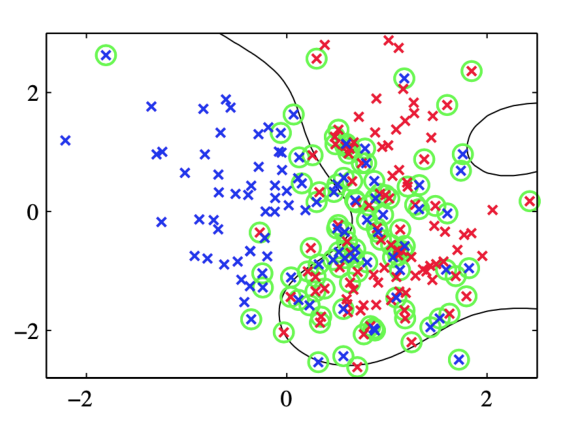

In [7]:
# 图7.4
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图7.4.png')
plt.axis('off')
ax.imshow(d)


图 7.4 v-SVM应用于二维不可分数据集的例子。圆圈表示支持向量。

这里使用了形如$ exp(−\gamma\Vert x − x' \Vert^2) $的高斯核，且$ \gamma = 0.45 $。


虽然对新输入的预测只通过支持向量完成，但是训练阶段（即确定参数$ a, b $的阶段）使用了整个数据集，因此找到一个解决二次规划问题的高效算法很重要。我们首先注意到由公式（7.10）或式（7.31）给出目标函数$ \tilde{L}(a) $是二次的，因此如果限制条件定义了一个凸区域（由于限制条件的线性性质，实际情况确实是这样），那么任意局部最优解也是全局最优解。因为需要的计算量和存储空间都相当大，所以使用传统的方法直接求解二次规划问题通常是不可行的，因此我们需要寻找更实际的方法。分块（chunking）方法（Vapnik, 1992）利用了如果我们将核矩阵中对应于拉格朗日乘数等于零的行和列删除，那么拉格朗日函数是不变的这一事实。这使得完全的二次规划问题被分解为一系列小的二次规划问题，这些小的问题的目标是识别出所有的非零拉格朗日乘数，然后丢弃其它的。分块可以通过保护共轭梯度（protected conjugate gradient）方法实现（Burges, 1998）。虽然分块可以将二次函数中矩阵的大小从数据点的个数的平方减小到近似等于非零拉格朗日乘数的个数的平方，但是对于大规模应用来说，这个数量仍然过大，从而内存无法满足要求。分解方法（decomposition method）（Osuna et al., 1996）也解决一系列较小的二次规划问题，但是这些问题被设计为具有固定的大小，这个方法可以应用于任意规模的数据集。然而，这种方法仍然涉及到二次规划子问题的数值解，求出这些数值解是很困难的，代价很高的。一种最流行的训练支持向量机方法是被称为顺序最小化优化（sequential minimal optimization），或称为SMO（Platt, 1999）。这种方法考虑了分块方法的极限情况，每次只考虑两个拉格朗日乘数。这种情况下，子问题可以解析地求解，因此避免了数值二次规划。选择每一步骤中需要考虑的拉格朗日乘数对时，使用了启发式的方法。在实际应用中，SMO与训练数据点数量的关系位于线性与二次之间，取决于具体的应用。


我们已经看到核函数对应于特征空间中的内积。特征空间可以是高维的，甚至是无穷维的。 通过直接对核函数操作，而不显式地引入特征空间，支持向量机或许在一定程度上避免了维度灾难的问题。然而，因为限制了特征空间维度的特征的值之间存在限制，是哟一事实并非如此。为了说明这一点，考虑一个简单的二阶多项式核，我们可以用它的分量进行展开
$ \begin{eqnarray} k(x,z) &=& (1 + x^Tz)^2 = (1 + x_1z_1 + x_2z_2)^2 \\ &=& 1 + 2x_1z_1 + 2x_2z_2 + x_1^2z_1^2 + 2x_1z_1x_2z_2 + x_2^2z_2^2 \\ &=& (1,\sqrt{2}x_1,\sqrt{2}x_2,\sqrt{2}x_1x_2,x_2^2)(1,\sqrt{2}z_1,\sqrt{2}z_2,z_1^2,\sqrt{2}z_1z_2,z_2^2)^T \\ &=& \phi(x)^T\phi(z) \tag{7.42} \end{eqnarray} $
于是这个核函数表示六维特征空间中的一个内积，其中输入空间到特征空间的映射由向量函数$ \phi(x) $描述。然而，对这些特征加权的系数被限制为具体的形式。因此，原始二维空间$ x $中的任意点集都会被限制到这个六维特征空间中的二维非线性流形中。




我们已经强调，支持向量机不提供概率输出，而是对新的输入进行分类决策，这个事实。Veropoulos et al.(1999)讨论了对SVM的修改，使其能控制假阳性和假阴性之间的权衡。然而，如果我们希望把SVM用作较大的概率系统中的一个模块，那么我们需要对于新的输入$ x $的类别标签$ t $的概率预测。
为了解决这个问题，Platt(2000)提出了使用logistic sigmoid函数拟合训练过的支持向量机的输出的方法。具体来说，需要求解的条件概率被假设具有
$ p(t=1|x) = \sigma(Ay(x) + B) \tag{7.43} $
这样的形式，其中$ y(x) $由式（7.1）定义。参数$ A,B $的值通过最小化交叉熵误差函数的方式确定。交叉熵误差函数根据由$ y(x_n), t_n $组成的训练数据集定义。为了避免严重的过拟合现象，用于拟合sigmoid函数的数据需要独立于训练原始SVM的数据。这种两个阶段的方法等价于假设支持向量机的输出$ y(x) $表示属于类别$ t = 1 $的$ x $的对数概率。由于SVM的训练过程并没有体现这种倾向，因此SVM给出的对后验概率的近似结果比较差(Tipping, 2001)。



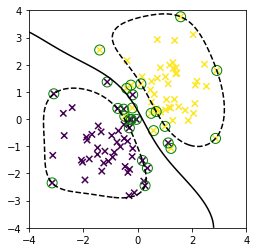

In [4]:
# 例子
def create_toy_data():
    x0 = np.random.normal(size=100).reshape(-1, 2) - 1.
    x1 = np.random.normal(size=100).reshape(-1, 2) + 1.
    x = np.concatenate([x0, x1])
    y = np.concatenate([-np.ones(50), np.ones(50)]).astype(np.int)
    return x, y

x_train, y_train = create_toy_data()

model = SupportVectorClassifier(RBF(np.array([1., 0.5, 0.5])), C=1.)
model.fit(x_train, y_train)

x0, x1 = np.meshgrid(np.linspace(-4, 4, 100), np.linspace(-4, 4, 100))
x = np.array([x0, x1]).reshape(2, -1).T
plt.scatter(x_train[:, 0], x_train[:, 1], s=40, c=y_train, marker="x")
plt.scatter(model.X[:, 0], model.X[:, 1], s=100, facecolor="none", edgecolor="g")
plt.contour(x0, x1, model.distance(x).reshape(100, 100), np.arange(-1, 2), colors="k", linestyles=("dashed", "solid", "dashed"))
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.gca().set_aspect("equal", adjustable="box")

## 7.1.2与logistic回归的关系

与线性可分的情形一样，对于线性不可分的概率分布，我们可以用最小化正则化的误差函数的方法重新表示SVM。这也使得我们能够强调与logistic回归模型之间的相似性和差别。
我们已经看到，对于位于边缘边界正确一侧的数据点，即满足$ y_nt_n \geq 1 $的数据点，我们有$ \xi_n = 0 $，对于剩余的数据点，有$ \xi_n = 1 − y_nt_n $。因此目标函数（7.21）可以写成（忽略整体的具有可乘性的常数）
$ \sum\limits_{n=1}^NE_{SV}(y_nt_n) + \lambda\Vert w \Vert^2 \tag{7.44} $
这样的形式。其中$ \lambda = (2C)^{−1} $，$ E_{SV}(.) $是定义为
$ E_{SV}(y_nt_n) = [1 - y_nt_n]_{+} \tag{7.45} $
的铰链(hinge)误差函数，其中$ [.]_{+} $表示正数部分。这个函数之所以被称为“铰链”误差函数，是因为它的形状，如图7.5所示。

它可以被看做**误分类误差函数的一个近似**。误分类误差函数是我们在理想情况下希望最小化的函数，它也被画在了图7.5中。


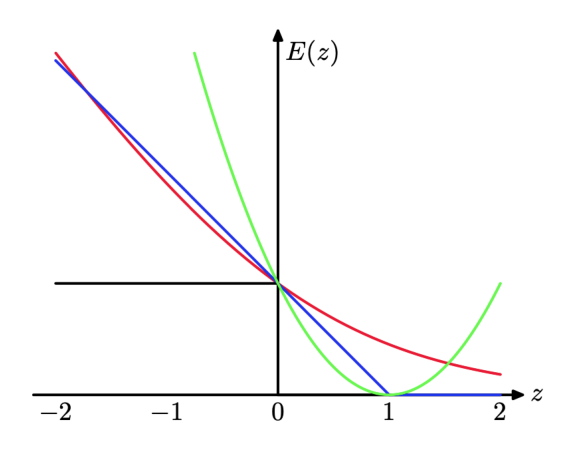

In [11]:
# 图7.5
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图7.5.png')
plt.axis('off')
ax.imshow(d)

图 7.5 支持向量机使用的“铰链”误差函数的图像，用蓝色表示。同时画出的还有logistic回归的误差函数，使用因子$ 1/\ln(2) $重新缩放，从而通过点$ (0, 1) $，用红色表示。还画出了误分类误差函数（黑色）和平方误差函数（绿色）。

当我们考虑4.3.2节的logistic回归模型的时候，我们发现比较方便的做法是对目标变量$ t \in {0, 1} $进行操作。为了与支持向量机进行对比，我们首先使用目标变量$ t \in {−1, 1} $重写最大似然logistic回归函数。为了完成这一点，我们注意到$ p(t=1|y) = \sigma(y) $，其中$ y(x) $由式（7.1）给出，$ \sigma(y) $是式（4.59）给出的logistic sigmoid函数。因此有$ p(t = −1|y) = 1 − \sigma(y) = \sigma(−y) $，其中我们用到了logistic sigmoid函数的性质，因此我们有
$ p(t|y) = \sigma(yt) \tag{7.46} $
从这个式子中我们可以通过对似然函数取负对数的方式构造一个误差函数。带有正则化项的误差函数的形式为
$ \sum\limits_{n=1}^NE_{LR}(y_nt_n) + \lambda\Vert w \Vert^2 \tag{7.47} $
其中
$ E_{LR}(yt) = \ln(1 + exp(-yt)) \tag{7.48} $
为了与其他的误差函数进行比较，我们可以除以$ \ln(2) $使得误差函数通过点$ (0, 1) $。重新标度的误差函数也被画在了图7.5中。我们看到它的形式与支持向量机的误差函数类似。**关键的区别在于$ E_{SV}(yt) $的平台区域产生了稀疏解**。

**logistic误差函数与铰链损失都可以看成对误分类误差函数的连续近似**。有时用于解决分类问题的另一个连续近似的误差函数时**平方和误差函数**，也被画在了图7.5中。但是，它具有：**会着重强调那些被正确分类的在正确的一侧距离决策边界较远的点的性质**。如果这些点是误分类的点，那么这些点也会被赋予较高的权值。因此如果我们的目标是最小化分类错误率，那么一个单调递减的误差函数是一个更好的选择。



In [17]:
# 推导7.47

参考资料：
- http://sioramen.sub.jp/prml_wiki/doku.php/prml演習7.6

## 7.1.3 多类svm

基本的支持向量机时一个两类分类器。然而在实际应用中，我们经常要处理涉及到$ K > 2 $个类别的问题。于是，将**多个两类**SVM组合构造多类分类器的方法被提出来。

一种常用的方法(Vapnik, 1998)是构建$ K $个独立的SVM，其中第$ k $个模型$ y_k(x) $在训练时，使用来自类别$ C_k $的数据作为正例，使用来自剩余的$ K − 1 $个类别的数据作为负例。这被称为**“1对剩余”(one-versus-the-rest)方法**。然而，在图4.2中，我们看到使用独立的分类器进行决策会产生**不相容**的结果，其中一个输入会同时被分配到多个类别中。这个问题有时可以通过：对于新的输入$ x $，使用
$ y(x) = \max_ky_k(x) \tag{7.49} $
做预测，来解决。不幸的是，这种启发式的方法会产生：**不同的分类器是在不同的任务上进行训练的，无法保证不同分类器产生的实数值$ y_k(x) $具有恰当的标度的问题**。

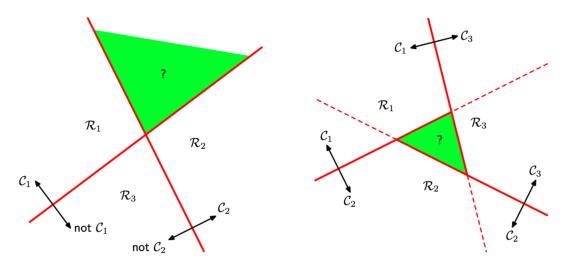

In [12]:
# 图4.2
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图4.2.png')
plt.axis('off')
ax.imshow(d)


“1对剩余”方法的另一个问题是**训练集合不平衡**。例如，如果我们有$ 10 $个类别，每个类别的训练数据点的数量相同，那么用于训练各个独立的**分类器的训练数据由$ 90% $的负例和仅仅$ 10% $的正例组成**，从而原始问题的对称性就消失了。Lee et al.(2001)提出了“1对剩余”方法的一种变体。这种变体**修改了目标值**，使得正例类别的目标值为$ +1 $，负例类别的目标值为$ − 1 / (K - 1) $。

Weston and Watkins(1999)定义了一个**单一目标函数用来同时训练所有的$ K $个SVM，基于的是最大化每个类别与其余剩余类别的边缘**。然而，这会导致训练过程变慢，因为这种方法需要求解的不是N个数据点上的$ K $个独立的最优化问题（整体代价为$ O(KN^2) $），而是要求解一个规模为$ (K − 1)N $的单一的最优化问题，整体代价为$ O(K^2N^2) $。

**另一种方法是在所有可能的类别对之间训练$ K(K−1) / 2 $个不同的二分类SVM，然后将测试数据点分到具有最高“投票数”的类别中去。这种方法有时被称为“1对1”（one-versus-one）**。同样的，我们从图4.2可以看到这会导致最终分类的歧义性。且对于较大的$ K $，这种方法要比“1对剩余”的方法花费更多的训练时间。类似地，为了计算数据点，这种方法需要更多的计算。

后一个问题可以通过将每对分类器组织成有**向无环图**（不要与概率图模型弄混淆）的方式解决，这就产生了DAGSVM（Platt et al., 2000）。对于$ K $个类别，DAGSVM共有$ K(K−1) / 2 $个分类器。每次对新的测试点分类时，只需要$ K − 1 $对分类器进行计算。选定的分类器是根据遍历图的路径确定的。

Dietterich and Bakiri(1995)提出了一种不同的方法解决多分类问题。**这种方法基于的是误差-修正输出编码**，并且被Allwein et al.(2000)用到支持向量机中。这种方法可以被看做“1对1”投票方法的一个推广。这种方法中，用来训练各个分类器的类别划分的方式更加一般。$ K $个类别本身被表示为选定的两类分类器产生的响应的集合。结合一套合适的解码方法，这种方法对于错误以及各个分类器的输出的歧义性具有鲁棒性。虽然将SVM用于多分类问题仍然是**一个没有标准答案的问题，但是在实际应用中，“1对剩余”是被最广泛使用的方法，尽管它有特定的形式，并且有着实际应用的局限性**。

也存在**单一类别（single-class）支持向量机**，它解决与概率密度估计相关的无监督学习问题。但是，这种方法不是用来对数据的概率密度建模，而是**想找到一个光滑的边界将高密度的区域包围起来**。边界用来表示概率密度的等分点，即从概率密度分布中抽取的一个数据点落在某个区域的概率由一个0到1之间的固定的数给出，这个数事先指定好。与进行整体的密度估计相比，这个问题更加受限，但是对于某些具体的应用已经足够了。关于使用支持向量机解决这个问题，已经有两种方法被提出来。Scholkopf et al.(2001)的算法尝试找到一个超平面，将训练数据中的固定比例$ v $的数据从原始数据集中分离，同时最大化超平面与原点之间的距离（边缘）。Tax and Duin(1999)寻找特征空间中包含数据集的ν比例数据的最小球体。对于只是$ x − x' $的函数的核$ k(x, x') $，这两种算法等价。



## 7.1.4 回归问题的svm

我们现在将支持向量机推广到**回归问题，同时保持它的稀疏性**。在简单的线性回归模型中，我们最小化一个正则化的误差函数
$ \frac{1}{2}\sum\limits_{n=1}^N{y_n - t_n}^2 + \frac{\lambda}{2}\Vert w \Vert^2 \tag{7.50} $
为了得到稀疏解，二次误差函数被替换为**一个$ \epsilon $-不敏感误差函数**（$ \epsilon $-insensitive error function）（Vapnik, 1995）。如果预测$ y(x) $和目标$ t $之间的差的绝对值小于$ \epsilon $，那么这个误差函数给出的误差等于零，其中$ \epsilon > 0 $。$ \epsilon $-不敏感误差函数的一个简单的例子是

$$
E_{\epsilon}(y(\boldsymbol{x})-t)=\left\{\begin{array}{lr}
0, & \text { if }|y(\boldsymbol{x})-t|<\epsilon \\
|y(\boldsymbol{x})-t|-\epsilon & \text { otherwise }
\end{array}\right.
 \tag{7.51} $$
它在不敏感区域之外，会有一个与误差相关联的**线性代价**。如图7.6所示。

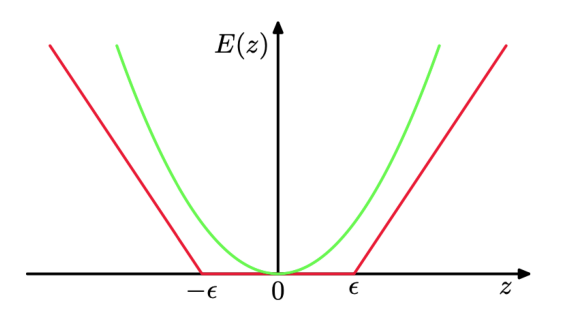

In [13]:
# 图7.6
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图7.6.png')
plt.axis('off')
ax.imshow(d)

图 7.6 $ \epsilon $-不敏感误差函数（红色）在不敏感区域之外,误差函数值随着距离线性增大。作为对比，同时给出了二次误差函数（绿色）。

于是我们最小化正则化的误差函数，形式为
$ C\sum\limits_{n=1}^NE_{\epsilon}(y(x) - t_n) + \frac{1}{2}\Vert w \Vert^2 \tag{7.52} $
其中$ y(x) $由式（7.1）给出。按照惯例，**（起着相反作用的）**正则化参数被记作$ C $，出现在误差项之前。

与之前一样，**通过引入松弛变量的方式**，我们可以重新表达最优化问题。对于每个数据点$ x $，我们现在需要两个松弛变量$ \xi \geq 0 $和$ \xi \geq 0 $，其中$ \xi > 0 $对应于$ t > y(x) + \epsilon $的数据点，$ \hat{\xi} > 0 $对应于$ t_n < y(x_n) − \epsilon $的数据点，如图7.7所示。

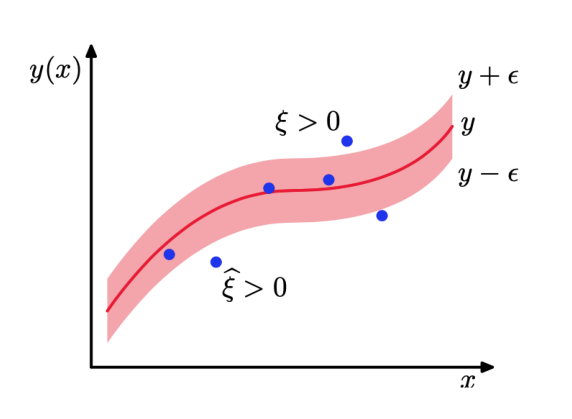

In [14]:
# 图7.7
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图7.7.png')
plt.axis('off')
ax.imshow(d)

图 7.7 SVM回归的说明。图中画出了回归曲线以及$ \epsilon $-不敏感“管道”。同时给出的是松弛变量$ \xi $和$ \hat{\xi} $的例子。对于$ \epsilon $-管道上方的点，$ \xi > 0 $且$ \xi = 0 $，对于$ \epsilon $-管道下方的点，$ \xi = 0 $且$ \xi > 0 $，对于$ \epsilon $-管道内部的点$ \xi = \hat{\xi} = 0 $。

目标点位于$ \epsilon $-管道内的条件是$ y_n − \epsilon \leq t_n \leq y_n + \epsilon $，其中$ y_n = y(x_n) $。引入松弛变量使得数据点能够位于管道之外，只要松弛变量不为零即可。对应的条件变为
$ \begin{eqnarray} t_n \leq y(x_n) + \epsilon + \xi_n \tag{7.53} \\ t_n \geq y(x_n) - \epsilon - \hat{\xi_n} \tag{7.54} \end{eqnarray} $
这样，支持向量回归的误差函数就可以写成
$ C\sum\limits_{n=1}^N(\xi_n + \hat{\xi_n} + \frac{1}{2}\Vert w \Vert^2) \tag{7.55} $
它必须在限制条件$ \xi_n \geq 0 $和$ \hat{\xi_n} \geq 0 $和式（7.53），（7.54）下进行最小化。通过引入拉格朗日乘数$ a_n \geq 0, a_n \geq 0, \mu_n \geq 0 $以及$ \mu_n \geq 0 $，然后最优化拉格朗日函数
$ \begin{eqnarray} L = &C& \sum\limits_{n=1}^N(\xi_n + \hat{\xi_n}) + \frac{1}{2}\Vert w \Vert^2 - \sum\limits_{n=1}^N(\mu_n\xi_n + \hat{\mu_n}\hat{\xi_n}) \\ &-& \sum\limits_{n=1}^Na_n(\epsilon + \xi_n + y_n - t_n) - \sum\limits_{n=1}^N\hat{a_n}(\epsilon + \hat{\xi_n} - y_n + t_n) \tag{7.56} \end{eqnarray} $


我们现在使用式（7.1）替换$ y(x) $，然后令拉格朗日函数关于$ w, b, \xi_n $和$ \xi_n $的导数为0，得到：
$ \begin{eqnarray} \frac{\partial L}{\partial w} = 0 &\rightarrow& w = \sum\limits_{n=1}^N(a_n - \hat{a}n)\phi(x_n) \tag{7.57} \\ \frac{\partial L}{\partial b} = 0 &\rightarrow& \sum\limits{n=1}^N(a_n - \hat{a}_n) = 0 \tag{7.58} \\ \frac{\partial L}{\partial \xi_n} = 0 &\rightarrow& a_n + \mu_n = C \tag{7.59} \\ \frac{\partial L}{\partial \hat{\xi_n}} = 0 &\rightarrow& \hat{a}_n + \hat{\mu}_n = C \tag{7.60} \end{eqnarray} $
使用这些结果消去拉格朗日函数中对应的变量，我们看到对偶问题涉及到关于$ {a_n} $和$ {\hat{a}_n} $最大化
$ \begin{eqnarray} \tilde{L}(a,\hat{a}) = &-&\frac{1}{2}\sum\limits_{n=1}^N\sum\limits_{m=1}^N(a_n - \hat{a}_n)(a_m - \hat{a}m)k(x_n,x_m) \\ &-&\epsilon\sum\limits{m=1}^N(a_n - \hat{a}n) + \sum\limits{m=1}^N(a_n - \hat{a}_n)t_n \tag{7.61} \end{eqnarray} $
其中我们已经引入了核$ k(x, x') = \phi(x)^T\phi(x') $。与之前一样，这是一个具有限制条件的最大化问题。为了找到限制条件，我们注意到，因为$ a_n, \hat{a}_n $是拉格朗日乘数，所以它们要满足$ a_n \geq 0 $和$ \hat{a}_n \geq 0 $必须成立。且$ \mu_n \geq 0 $和$ \hat{\mu}_n \geq 0 $以及式（7.59）（7.60）要求$ a_n \leq C $且$ \hat{a}_n \leq C $，因此我们又一次得到盒限制
$ \begin{eqnarray} 0 \leq a_n \leq C \tag{7.62} \\ 0 \leq \hat{a}_n \leq C \tag{7.63} \end{eqnarray} $
以及条件（7.58）。

In [16]:
# 推导7.61


将式（7.57）代入式（7.1），我们看到对于新的输入变量，可以使用
$ y(x) = \sum\limits_{n=1}^N(a_n - \hat{a}_n)k(x,x_n) + b \tag{7.64} $
进行**预测**，这又一次被表示为核函数的形式。

对应的Karush-Kuhn-Tucker（KKT）条件说明了在解的位置，对偶变量与限制的乘积必须等于0，形式为
$ \begin{eqnarray} a_n(\epsilon + \xi_n + y_n - t_n) &=& 0 \tag{7.65} \\ \hat{a}_n(\epsilon + \hat{\xi}_n + y_n - t_n) &=& 0 \tag{7.66} \\ (C - a_n)\xi_n &=& 0 \tag{7.67} \\ (C - \hat{a}_n)\hat{\xi}_n &=& 0 \tag{7.68} \end{eqnarray} $
根据这些条件，我们能得到一些有用的结果。首先，我们注意到如果$ \epsilon + \xi_n + y_n − t_n = 0 $，那么系数$ a_n $只能非零，这表明数据点要么位于$ \epsilon $-管道的上边界上（$ \xi_n = 0 $），要么位于上边界的上方（$ \xi > 0 $）。类似地，$ \hat{a}_n $的非零值表示$ \epsilon + \xi − y_n + t_n = 0 $，这些点必须位于$ \epsilon $-管道的下边界上或下边界的下方。

此外，由于将两式相加，注意到$ \xi_n $和$ \hat{\xi}_n $是非负的，而$ \epsilon $是严格为正的，因此对于每个数据点$ x_n,a_n $或$ \hat{a_n} $至少一个为0，或都为0。**所以$ \epsilon + \xi_n + y_n − t_n = 0 $和$ \epsilon + \xi_n − y_n + t_n = 0 $这两个限制是不兼容的**。

支持向量是对于由式（7.64）给出的预测**有贡献的数据点**，换句话说，就是那些使得$ a_n \neq 0 $或$ \hat{a}_n \neq 0 $成立的数据点。这些数据点位于$ \epsilon $-管道边界上或者管道外部。管道内部的所有点都有$ a_n = \hat{a}_n = 0 $。我们又一次得到一个稀疏解，在预测模型（7.64）中唯一必须计算的项就是涉及到支持向量的项。




参数$ b $可以通过，**考虑一个数据点**，满足$ 0 < a_n < C $。根据式（7.67），一定有$ \xi_n = 0 $，根据式（7.65），一定有$ \epsilon + y_n − t_n = 0 $。使用式（7.1），然后求解$ b $得到。这时我们有
$ \begin{eqnarray} b &=& t_n - \epsilon - w^T\phi(x_n) \\ &=& t_n \epsilon - \sum\limits_{m=1}^N(a_m - \hat{a}_m)k(x_n,x_m) \tag{7.69} \end{eqnarray} $
其中我们使用了式（7.57）。通过考虑一个满足$ 0 < a_n < C $的数据点，我们可以得到一个类似的结果。在实际应用中，更好的做法是**对所有的这些b的估计进行平均**。

与分类问题的情形相同，有另一种用于回归的SVM的形式。这种形式的SVM中，控制复杂度的参数有一个更加直观的意义(Scholkopf et al., 2000)。特别地，**我们不固定不敏感区域$ \epsilon $的宽度，而是固定位于管道外部的数据点的比例$ v $**。这涉及到最大化
$ \begin{eqnarray} \tilde{L}(a,\hat{a}) = &-&\sum\limits_{n=1}^N\sum\limits_{m=1}^N(a_n - \hat{a}_n)(a_m - \hat{a}m)k(x_n,x_m) \\ &+&\sum\limits{m=1}^N(a_n - \hat{a}_n)t_n \tag{7.70} \end{eqnarray} $
限制条件为
$ \begin{eqnarray} 0 \leq a_n &\leq& \frac{C}{N} \tag{7.71} \\ 0 \leq \hat{a}n &\leq& \frac{C}{N} \tag{7.72} \\ \sum\limits{n=1}^N(a_n - \hat{a}n) &=& 0 \tag{7.73} \\ \sum\limits{n=1}^N(a_n + \hat{a}_n) &\leq& vC \tag{7.74} \end{eqnarray} $
可以**证明至多有$ vN $个数据点落在不敏感管道外部，而至少有$ vN $个数据点是支持向量，因此位于管道上或者管道外部。**
图7.8说明了使用支持向量机解决回归问题的一个例子，数据集使用的是正弦曲线数据集。

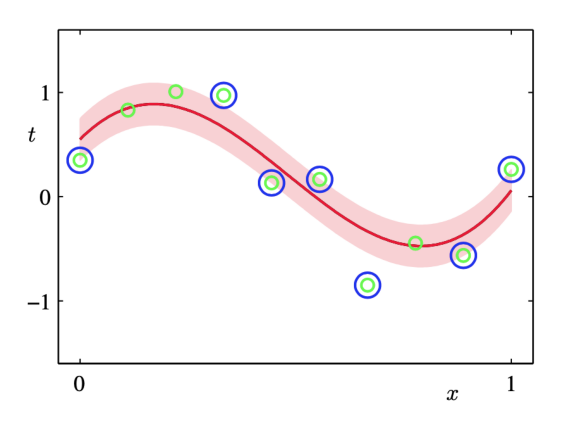

In [15]:
# 图7.8
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图7.8.png')
plt.axis('off')
ax.imshow(d)

图 7.8 $ v $-SVM回归应用到人工生成的正弦数据集上的说明，SVM使用了高斯核。预测分布曲线为红色曲线，$ \epsilon $-不敏感管道对应于阴影区域。此外，数据点用绿色表示，支持向量用蓝色圆圈标记。
这里参数$ v $和$ C $已经手动选择完毕。在实际应用中，它们的值通常通过交叉验证的方法确定。

参考资料：
- https://tips-memo.com/prml-7-7

## 7.1.5 计算学习理论

历史上，支持向量机大量地使用一个被称为**计算学习理论**（computational learning theory)）的理论框架进行分析。这个框架有时候也被称为统计学习理论（statistical learning theory）（Anthony and Biggs, 1992; Kearns and Vazirani, 1994; Vapnik, 1995; Vapnik, 1998）。这个框架起源于Valiant（1984），他建立了概率近似正确（probably approximately correct）或称为PAC的学习框架。PAC学习框架的目标是理解为**两个给出较好的泛化能力，需要多大的数据集**。**这个框架也给出了学习的计算代价的界限**，虽然我们不会在这里讨论。

假设我们从联合概率分布$ p(x,t) $中抽取一个大小为$ N $的数据集$ D $，其中$ x $是输入变量，$ t $表示类别标签。我们把注意力集中于“无噪声”的情况，即类别标签由某个（未知的）判别函数$ t = g(x) $确定。在PAC学习中，空间$ F $是一个以训练集$ D $为基础的函数组成的空间，我们从空间$ F $中抽取一个函数$ f(x;D) $，**如果它的期望错误率小于某个预先设定的阈值$ \epsilon $**，即
$ \mathbb{E}_{x,t}[I(f(x;D) \neq t)] < \epsilon \tag{7.75} $
**那么我们就说函数$ f(x;D) $具有较好的泛化能力**。其中$ I(\dot) $是示性函数，期望是关于概率分布$ p(x,t) $的期望。式子左手边的项是一个随机变量，因为它依赖于训练数据集$ D $。PAC框架要求，对于从概率分布$ p(x,t) $中随机抽取的数据集$ D $，式（7.75）成立的概率要大于$ 1 − \delta $。这里$ \delta $是另一个预先设定的参数。术语“概率近似正确”来自于以一个较高的概率（大于$ 1 − \delta $），使得错误率较小（小于$ \epsilon $）这一要求。对于一个给定的模型空间$ F $，以及给定的参数$ \epsilon, \delta $，**PAC学习的目标是提供满足这个准则所需的最小数据集规模$ N $的界限**。在PAC学习中，一个关键的量是Vapnik-Chervonenkis维度（Vapnik-Chervonenkis dimension），或者被称为VC维度。它提供了函数空间复杂度的一个度量，使得PAC框架能够扩展到包含无穷多个函数的空间。

**在PAC框架中推导出的界限通常被看成是最坏的情况**，因为它们适用于概率分布$ p(x,t) $的任意选择，只要训练集和测试集是从相同的概率分布中（独立地）抽取即可，并且它们适用于函数$ f(x) $的任意选择，只要它属于$ F $即可。在真实世界的机器学习应用中，我们处理的分布通常有着很强的规律性，如输入空间中的大片区域有着相同的类别标签。由于缺少关于分布形式的任何假设，因此PAC边界非常保守，也就是说，**它们严重高估了得到给定的泛化性能所需的数据集的规模**。因此，PAC界限几乎没有任何实际用处。

一种**提升PAC界限的紧致程度的方法是PAC-贝叶斯框架**（PAC-Bayesian framework）（McAllester, 2003），它考虑了空间F上的函数的概率分布情况，有些类似于贝叶斯方法中的先验概率。这种方法仍然考虑任意可能的$ p(x,t) $的选择，因此虽然这种方法得到的界限更加紧致，但是它们仍然是非常保守的。



## 7.2 相关向量机

支持向量机被用于一系列的分类和回归的应用中。尽管这样，支持向量机还是有许多局限性，某些局限性已经在本章中讨论过了。特别地，SVM的输出是一个决策结果而不是后验概率。并且，SVM最开始用于处理二分类问题，因此推广到$ K > 2 $类有很多问题。**有一个复杂度参数$ C $或$ v $（以及回归问题中的参数$ \epsilon $）必须使用诸如交叉验证的方法确定**。最后，预测是用核函数的线性组合表示的，核函数以训练数据点为中心，并且必须是正定的。

相关向量机（relevance vector machine）或RVM（Tipping, 2001）是一个用于回归问题和分类问题的贝叶斯稀疏核方法，**它具有许多SVM的特征，同时避免了SVM的主要的局限性。此外，它通常会产生更加稀疏的模型，从而使得在测试集上的速度更快，同时保留了可比的泛化误差**。

与SVM不同，我们会发现比较方便的做法是首先介绍RVM的回归形式，然后将其扩展到分类任务中。

### 7.2.1 用于回归的RVM

用于回归的相关向量机的形式是第3章研究过的线性模型的形式，但是先验概率有所不同，从而产生了稀疏解。模型定义了给定一个输入向量$ x $的情况下，实值目标变量$ t $的条件概率分布为
$ p(t|x,w,\beta) = \mathcal{N}(t|y(x),\beta^{-1}) \tag{7.76} $
其中$ \beta = \sigma^{−2} $是噪声精度（噪声方差的逆），均值是由一个线性模型给出，形式为
$ y(x) = \sum\limits_{i=1}^Mw_i\phi_i(x) = w^T\phi(x) \tag{7.77} $
模型带有固定非线性基函数$ \phi_i(x) $，通常包含一个常数项，使得对应的权参数表示一个“偏置”。

相关向量机是这个模型的一个具体实例，它试图重现支持向量机的结构。特别地，基函数由核给出，训练集的每个数据点关联着一个核。一般的表达式（7.77）于是就可以写成与SVM相类似的形式
$ y(x) = \sum\limits_{n=1}^Nw_nk(x,x_n) + b \tag{7.78} $
其中$ b $是一个偏置参数。在目前的问题中，参数的数量为$ M = N + 1 $。$ y(x) $与SVM的预测模型（7.64）具有相同的形式，唯一的差别是系数$ a_n $在这里被记作$ w_n $。应该强调的是，后面的分析对于任意的基函数的选择都成立。为了一般情况，我们将对式（7.77）给出的形式进行操作。与SVM的情形相反，没有正定核的限制，基函数也没有被训练数据点的数量或位置所限制。


$ y(x) = \sum\limits_{n=1}^N(a_n - \hat{a}_n)k(x,x_n) + b \tag{7.64} $


假设我们有输入向量$ x $的$ N $次观测，我们将这些观测聚集在一起，记作数据矩阵$ X $，它的第$ n $行是$ x-n^T $，其中$ n = 1,...,N $。对应的目标值为$ t = (t_1,...,t_N)^T $。因此，似然函数为
$ p(t|X,w,\beta) = \prod\limits_{n=1}^Np(t_n|x_n,w,\beta) \tag{7.79} $
接下来我们引入参数向量$ w $上的先验分布。与第3章一样，我们考虑0均值的高斯先验。然而，RVM中的关键区别在于我们为每个权参数$ w_i $都引入了一个单独的超参数$ \alpha_i $，而不是一个共享的超参数。因此权值先验的形式为
$ p(w|\alpha) = \prod\limits_{i=1}^M\mathcal{N}(w_i|0,\alpha_i^{-1}) \tag{7.80} $
其中$ \alpha_i $表示对应参数$ w_i $的精度，$ \alpha $表示$ (\alpha_1,...,\alpha_M)^T $。我们将会看到，当我们关于这些超参数最大化模型证据时，大部分都趋于无穷，对应的权参数的后验概率分布集中在零附近。与这些参数关联的基函数于是对于模型的预测没有作用，因此被高效地剪枝掉，从而生成了一个稀疏的模型。


$ p(w|t) = \mathcal{N}(w|m_N,S_N) \tag{3.49} $
其中
$$ \begin{eqnarray} m_N &=& S_N(S_0^{-1}m_0 + \beta\Phi^Tt) \tag{3.50} \\ S_N^{-1} &=& S_0^{-1} + \beta\Phi^T\Phi \tag{3.51} \end{eqnarray} $$

使用式（3.49）给出的线性模型的结果，我们看到权值的后验概率分布还是高斯分布，形式为
$ p(w|t,X,\alpha,\beta) = \mathcal{N}(w|m,\Sigma) \tag{7.81} $
其中，均值和方差为
$ \begin{eqnarray} m &=& \beta\Sigma\Phi^Tt \tag{7.82} \\ \Sigma = (A + \beta\Phi^T\Phi)^-1 \tag{7.83} \end{eqnarray} $
其中，$ \Phi $是$ N \times M $的设计矩阵，元素为$ \Phi_{ni} = \phi_i(x_n) $，且$ A = diag(\alpha_i) $。注意在模型（7.78）的特殊情况下，我们有$ \Phi = K $，其中$ K $是元素为$ k(x_n,x_m) $的$ (N+1) \times (N+1) $对称核矩阵。


$ \alpha,\beta $的值可以通过第二类最大似然法（也被称为证据近似）来确定。这种方法中，我们最 大化通过对权向量积分得到的边缘似然函数：
$ p(t|X,\alpha,\beta) = \int p(t|X,w,\beta)p(w|\alpha)dw \tag{7.84} $
由于这表示两个高斯分布的卷积，因此可以得到对数边缘似然函数：
$ \begin{eqnarray} \ln p(t|X,\alpha,\beta) &=& \ln\mathcal{N}(t|O,C) \\ &=& -\frac{1}{2}{N\ln(2\pi) + \ln\vert C \vert + t^TC^{-1}t} \tag{7.85} \end{eqnarray} $
其中$ t = (t_1,...,t_N)^T $，且我们定义了形式为
$ C = \beta^{-1}I + \Phi A^{-1}\Phi^T \tag{7.86} $
的$ N \times N $的矩阵$ C $。


我们现在的目标是关于超参数$ \alpha, \beta $最大化式（7.85）。这只需要对3.5节给出的线性模型的证据近似进行微小的修改即可。我们可以区分出两种方法。第一种方法中，我们简单地令要求解的边缘似然函数的导数等于0，然后得到再估计方程：
$ \begin{eqnarray} \alpha_i^{new} &=& \frac{\gamma_i}{m_i^2} \tag{7.87} \\ (\beta^{new})^{-1} = \frac{\Vert t - \Phi_m \Vert^2}{N - \sum_i\gamma_i} \tag{7.88} \end{eqnarray} $
其中$ m_i $是式（7.82）定义的后验均值$ m $的第$ i $个分量。$ \gamma_i $定义为
$ \gamma_i = 1 - \alpha_i\Sigma_{ii} \tag{7.89} $
这度量了对应的参数$ w_i $由数据确定的效果。其中$ \Sigma_{ii} $是式（7.83）给出的后验协方差$ \Sigma $的第$ i $个对角元素。因此，学习过程按照，**首先选择$ \alpha, \beta $的初始值，分别使用式（7.82）和式（7.83）计算后验概率的均值和协方 差，然后交替地重新估计超参数（使用式（7.87）和式（7.88）进行）、重新估计后验均值与协方差（使用式（7.82）和式（7.83）进行），直到满足一个合适的收敛准则，这个步骤进行**。


第二种方法是**使用EM算法**，将在9.3.4节讨论。这两种寻找最大化证据的超参数值的方法在形式上是等价的。然而，在数值计算上，使用对应于式（7.87）和式（7.88）的直接最优化方法可以更快地收敛（Tipping, 2001）。

作为最优化的结果，我们发现超参数$ {\alpha_i} $的一部分趋于特别大的值（原则上是无穷大），因此对应于这些超参数的权参数$ w_i $的后验概率的均值和方差都是零。因此这些参数以及对应的基函数$ \phi_i(x) $被从模型中去掉，对于新输入的预测没有作用。在式（7.78）给出的模型中，对应于剩下的非零权值的输入$ x_n $被称为相关向量（relevance vector），因为它们是通过自动相关性检测的方法得到的，类似于SVM中的支持向量。然而，值得强调的一点是，通过自动相关性检测得到概率模型的稀疏性的方法是一种相当通用的方法，可以应用于任何表示成基函数的可调节线性组合形式的模型。

$ y(x) = \sum\limits_{n=1}^Nw_nk(x,x_n) + b \tag{7.78} $



$ p(t|x,w,\beta) = \mathcal{N}(t|y(x),\beta^{-1}) \tag{7.76} $
$ p(w|t,X,\alpha,\beta) = \mathcal{N}(w|m,\Sigma) \tag{7.81} $


找到了最大化边缘似然函数的超参数$ \alpha^*,\beta^* $的值之后，对于一个新的输入$ x $，我们可以计算$ t $上的预测分布。使用式（7.76）和式（7.81），预测分布为
$ \begin{eqnarray} p(t|x,X,t,\alpha^,\beta^) &=& \int p(t|x,w,\beta^)p(w|X,t,\alpha^*,\beta^*)dw \\ &=& \mathcal{N}(t|m^T\phi(x),\sigma^2(x)) \tag{7.90} \end{eqnarray} $
因此预测均值由式（7.76）给出，其中$ w $被设置为后验均值$ m $，预测分布的方差为
$ \sigma^2(x) = (\beta^*)^{-1} + \phi(x)^T\Sigma\phi(x) \tag{7.91} $
公式中的$ \Sigma $由式（7.83）给出，其中$ \alpha, \beta $被设置为最优值$ \alpha^*, \beta^* $。这类似于式（3.59）给出的线性回归模型的结果。回忆一下，对于局部的基函数，线性回归模型的预测方差在输入空间中没有基函数的区域会变小。于是，对于带有以数据点为中心的基函数的RVM的情形，当对数据以外的区域进行外插时，模型会对预测变得越来越确定（Rasmussen and Quinorro-Candela, 2005）,这当然不是我们想要的结果。高斯过程回归的预测分布没有这种问题。然而，高斯过程做预测的计算代价通常比RVM高得多。

图7.9给出了将RVM应用于正弦数据集回归问题的一个例子。
 


在实际应用中，我们对新的$ x $的值**预测**出$ t $比$ w $的值本身更感兴趣。这需要我们估计出定义为
$ p(t|\textbf{t},\alpha,\beta) = \int p(t|w,\beta)p(w|\textbf{t},\alpha,\beta)dw \tag{3.57} $

的预测分布。其中$ \textbf{t} $是训练集中的目标向量，且为了简化记号，我们省略了右边条件表达式中的输入向量。目标变量的条件分布由式（3.8）给出，后验分布由式（3.49）给出。我们看到式（3.57）涉及两个高斯分布的卷积，所以使用2.3.3节中得到的式（2.115）的结果，得到的预测分布的形式为：

$ p(t|x,\textbf{t},\alpha,\beta) = \mathcal{N}(t|m_N^T\phi(x),\sigma_N^2(x)) \tag{3.58} $
其中预测分布的方差$ \sigma_N^2(x) $是
$ \sigma_N^2(x) = \frac{1}{\beta} + \phi(x)^TS_N\phi(x) \tag{3.59} $

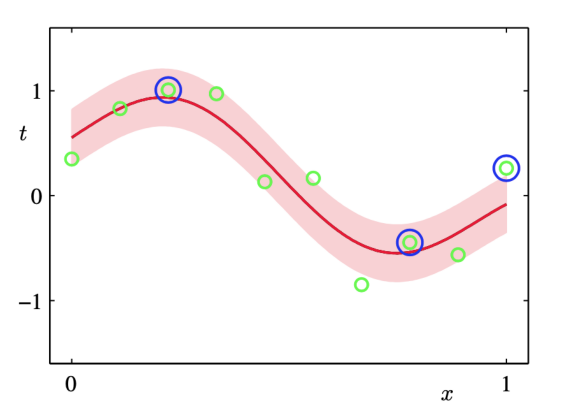

In [21]:
# 图7.9
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.imread('./graph/图7.9.png')
plt.axis('off')
ax.imshow(d)

图 7.9 使用与图7.8相同的数据集和相同的高斯核进行RVM回归的说明。RVM预测分布的均值用红色曲线表示，预测分布的一个标准差的位置用阴影区域表示。此外，数据点用绿色表示，相关向量用蓝色圆圈标记。注意，只有3个相关向量，而图7.8的$ v $-SVM有7个支持向量。

这里，噪声精度β也通过证据最大化的方式确定。我们看到RVM中先关向量的数量比SVM中使用的支持向量的数量少得多。对于一大类回归任务和分类任务，RVM生成的模型通常比对应的支持向量机生成的模型简洁了一个数量级，从而使得处理测试数据的速度有了极大的提升。值得注意的是，与SVM相比，这种稀疏性的增大并没有减小泛化误差。

与RVM相比，SVM的一个主要缺点是训练过程涉及到优化一个非凸的函数，并且与一个效果相似的SVM相比，训练时间要更长。对于有$ M $个基函数的模型，RVM需要对一个$ M \times M $的矩阵求逆，这通常需要$ O(M^3) $次操作。在类似SVM的模型（7.78）这一具体情形下，我们有$ M = N + 1 $。正如我们已经注意到的那样，存在训练SVM的高效方法，它的计算代价大致是N的二次函数。当然，在RVM的情况下，我们总可以在开始时将基函数的数量设置为小于$ N + 1 $。更重要的一点是，在相关向量机中，控制模型复杂度的参数以及噪声方差自动由一次训练过程确定，而在支持向量机中，参数$ C $和$ \epsilon $（或者$ v $）通常使用交叉验证的方法确定，这涉及到多次训练过程。此外，在下一节中，我们会推导另一种训练相关向量机的方法，它极大地提升了训练速度。




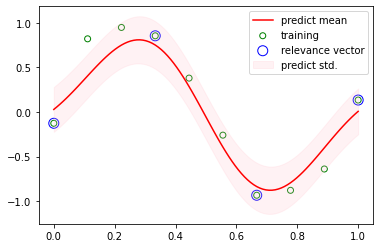

In [5]:
# 例子
def create_toy_data(n=10):
    x = np.linspace(0, 1, n)
    t = np.sin(2 * np.pi * x) + np.random.normal(scale=0.1, size=n)
    return x, t

x_train, y_train = create_toy_data(n=10)
x = np.linspace(0, 1, 100)

model = RelevanceVectorRegressor(RBF(np.array([1., 20.])))
model.fit(x_train, y_train)

y, y_std = model.predict(x)

plt.scatter(x_train, y_train, facecolor="none", edgecolor="g", label="training")
plt.scatter(model.X.ravel(), model.t, s=100, facecolor="none", edgecolor="b", label="relevance vector")
plt.plot(x, y, color="r", label="predict mean")
plt.fill_between(x, y - y_std, y + y_std, color="pink", alpha=0.2, label="predict std.")
plt.legend(loc="best")
plt.show()

参考文献：
- https://tips-memo.com/prml-7-9
- https://tips-memo.com/prml-7-10
- https://tips-memo.com/prml-7-11
- https://tips-memo.com/prml-7-12
- http://sioramen.sub.jp/prml_wiki/lib/exe/fetch.php/wiki/7.12.pdf

### 7.2.2 稀疏性分析

我们之前已经注意到自动相关性检测的过程使得参数的一个子集趋于零。我们现在更加详细地考察相关向量机的稀疏性的原理。在这个过程中，我们会得到一个与之前的直接方法相比更快的最优化超参数的方法。
关于贝叶斯线性模型的稀疏性的来源，在进行数学的分析之前，我们首先给出一些非形式化的观点。考虑一个数据集，这个数据集由$ N = 2 $个观测$ t_1 $和$ t_2 $组成。我们有一个基函数为$ \phi(x) $，超参数为$ \alpha $的模型，以及一个精度为$ \beta $的各向同性的噪声。根据式（7.85），边缘似然函数为$ p(t|\alpha,\beta) = \mathcal{N}(t|0,C) $，其中协方差矩阵的形式为
$ C = \frac{1}{\beta}I + \frac{1}{\alpha}\varphi\varphi^T \tag{7.92} $
其中$ \varphi $表示$N $维向量$ (\varphi(x_1), \varphi(x_2))^T $，类似地$ t = (t_1, t_2)^T $。注意，这是上的一个零均值的高斯过程模型，协方差为$ C $。给定的一个特定的观测，我们的目标是通过最大化边缘似然函数的方法找到$ \alpha^*, \beta^* $。从图7.10中，我们看到，如果$ \phi $的方向与训练数据向量之间没有很好的对齐的话，那么对应的超参数$ \alpha $会趋于$ \infty $，基向量会被从模型中剪枝掉。
 
图 7.10 贝叶斯线性回归模型的稀疏性的原理说明。图中给出了目标值的一组训练向量，形式为$ t = (t_1, t_2)^T $，用叉号表示，模型有一个基向量$ \phi = (\phi(x_1), \phi(x_2))^T $，它与目标数据向量的对齐效果很差。左图中，我们看到一个只有各向同性的噪声的模型，因此$ C = \beta^{−1}I $，对应于$ \alpha = \infty $，$ \beta $被设置为概率最高的值。右图中，我们看到了同样的模型，但是$ \alpha $的值变成了有限值。在两种情况下，红色椭圆都对应于单位马氏距离，$ \vert C \vert $对于两幅图的取值相同，而绿色虚线圆表示由项$ \beta^{−1} $产生的噪声的贡献。我们看到$ \alpha $的任意有限值减小了观测数据的概率，因此对于概率最高的解，基向量被移除。
这种现象出现的原因是$ \alpha $的任意有限值总会给数据一个较低的概率，因此就减小了$ t $的值，假设$ \beta $被设置为最优值。 我们看到$ \alpha $的任意有限值会使得分布在远离数据的方向被拉长，从而增加了远离观测数据的区域的概率质量，因此就减小了目标数据向量本身的概率密度的值。对于更一般的$ M $个基向量$ \phi_1,...,\phi_M $的情形，也有类似的直观含义，即如果垂直的基向量与数据向量$ t $没有很好地对齐，那么它很可能被从模型中剪枝掉。
我们现在从一个更加数学的角度，对于涉及到$ M $个基函数的一般情形，考察稀疏性的原理。为了进行这个分析，我们首先注意到，在式（7.87）给出的参数$ \alpha_i $的重新估计的结果中，右侧的项本身也是$ \alpha_i $的函数。于是这些结果表示隐式解，需要用迭代的方式求出，即使对于所有的$ j \neq i $的$ \alpha_j $都固定时，确定单一的$ \alpha_i $也需要迭代。
这给出了解决RVM的最优化问题的一个不同的方法，其中我们显式地写出边缘似然函数（7.85）中所有对特定的$ \alpha_i $的依赖关系，然后显式地确定驻点（Faul and Tipping, 2002; Tipping and Faul, 2003）。为了完成这一点，我们首先写出由式（7.86）定义的矩阵$ C $中来自$ \alpha_i $的贡献，即：
$ \begin{eqnarray} C &=& \beta^{-1}I + \sum\limits_{j \neq i}\alpha_j^{-1}\varphi_j\varphi_j^T + \alpha_i^{-1}\varphi_i\varphi_i^T \\ &=& C_{-i} + \alpha_i^{-1}\varphi_i\varphi_i^T \tag{7.93} \end{eqnarray} $
其中$ \phi_i $表示矩阵$ \Phi $的第$ i $列，即$ N $维向量，元素为$ (\phi_i(x_1),...,\phi_i(x_N)) $。这与$ \phi_n $不同，它表示的是$ \Phi $的第$ n $行。矩阵$ C^{−i} $表示将基函数i的贡献删除之后的矩阵C。使用矩阵恒等式(C.7)和 (C.15),矩阵C 的行列式和逆矩阵可以写成
$ \begin{eqnarray} \vert C \vert = \vert C_{-i} \vert(1+\alpha_i^{-1}\varphi_i^TC_{-i}^{-1}\varphi_i) \tag{7.94} \\ C^{-1} = C_{-i}^{-1} - \frac{C_{-i}^{-1}\varphi_i\varphi_i^TC_{-i}^{-1}}{\alpha_i + \varphi_i^TC_{-i}^{-1}\varphi_i} \tag{7.95} \end{eqnarray} $
使用这些结果，我们可以将对数边缘似然函数（7.85）写成下面的形式。
$ L(\alpha) = L(\alpha_{-i}) + \lambda(\alpha_i) \tag{7.96} $
其中$ L(\alpha_{−i}) $是省略了基函数$ \phi_i $的对数边缘似然函数，$ \lambda(\alpha_i) $被定义为
$ \lambda(\alpha_i) = \frac{1}{2}\left[\ln\alpha_i - \ln(\alpha_i + s_i) + \frac{q_i^2}{\alpha_i + s_i}\right] \tag{7.97} $
包含了所有依赖于$ \alpha_i $的项。这里我们引入了两个量
$ \begin{eqnarray} s_i &=& \varphi_i^TC_{-i}^{-1}\varphi_i \tag{7.98} \\ q_i &=& \varphi_i^TC_{-i}^{-1}t \tag{7.99} \end{eqnarray} $
这里$ s_i $被称为稀疏度（sparsity），$ q_i $被称为$ \varphi_i $的质量（quality），并且正如我们将要看到的那样，$ s_i $的值相对于$ q_i $的值较大意味着基函数$ \varphi_i $更可能被模型剪枝掉。“稀疏度”度量了基函数$ \varphi_i $与模型中其他基函数重叠的程度，“质量”度量了基向量$ \varphi_i $与误差向量之间的对齐程度，其中误差向量是训练值$ t = (t_1,...,t_N)^T $与会导致$ \varphi_i $从模型中被删除掉的预测向量$ y_{−i} $之间的差值（Tipping and Faul, 2003）。
在边缘似然函数关于$ \alpha_i $的驻点处，导数
$ \frac{d\lambda(\alpha_i)}{d\alpha_i} = \frac{\alpha_i^{-1}s_i^2 - (q_i^2 - s_i)}{2(\alpha_i + s_i)^2} \tag{7.100} $
等于0。有两种可能形式的解。回忆一下$ \alpha_i \geq 0 $，我们看到如果$ q_i^2 < s_i $，那么$ \alpha_i \to \infty $提供了一个解。相反，如果$ q_i^2 > s_i $，我们可以解出$ \alpha_i $，得
$ \alpha_i = \frac{s_i^2}{q_i^2 - s_i} \tag{7.101} $
图7.11给出了这两个解。
 
图 7.11 对数边缘似然$ \lambda(\alpha_i) $与$ \ln\alpha_i $的图像。左图中，单一的最大值出现在有限的$ \alpha_i $处，此时$ q_i^2 = 4 $且$ s_i = 1 $（从而$ q_i^2 > s_i $）。右图中，最大值位于$ \alpha_i = \infty $的位置，此时$ q_i^2 = 1 $且$ s_i = 2 $（从而$ q_i^2 < s_i $）。
我们看到质量项和稀疏度项的相对大小确定了一个特定的基向量是否会被模型剪枝掉。一个更加复杂的分析（Faul and Tipping, 2002）基于边缘似然函数的二阶导数，确保了这些解确实是$ \lambda(\alpha_i) $的唯一最大值。
注意，在给定其他超参数的值的情况下，这种方法产生了$ \alpha_i $的一个解析解。结合对于RVM中稀疏性来源的分析，上述分析也产生了一个高速最优化超参数的实用算法。这种算法使用固定的候选基向量集合，然后在集合上循环，确定每个向量是否应该被包含在模型中。最终的顺序稀疏贝叶斯学习算法描述如下。
- 如果求解回归问题，初始化$ \beta $。
- 使用一个基函数$ \phi_1 $进行初始化，用式（7.101）确定超参数$ \alpha_1 $，其余的$ j \neq 1 $的超参数$ \alpha_j $被初始化为无穷大，从而只有$ \varphi_1 $被包含在模型中。
- 对于所有基函数，计算$ \Sigma, m $，以及$ q_i $和$ s_i $。
- 选择一个候选的基函数$ \varphi_i $。
- 如果$ q-i^2 > s_i $且$ \alpha_i < \infty $，从而基向量$ \varphi_i $已经被包含在了模型中，那么使用式（7.101)更新$ \alpha_i $ 。
- 如果$ q-i^2 > s_i $且$ \alpha_i = \infty $，那么将$ \varphi_i $添加到模型中，使用式（7.101）计算$ \alpha_i $。
- 如果$ q-i^2 \leq s_i $且$ a_i < \infty $，那么从模型中删除基函数$ \varphi_i $，令$ \alpha_i = \infty $。
- 如果求解回归问题，更新$ \beta $。
- 如果收敛，则算法终止，否则回到第3步。

注意，如果$ q_i^2 \leq s_i $且$ \alpha_i = \infty $，那么基函数$ \phi_i $已经从模型中被去除掉了，不需要采取动作。
在实际应用中，比较方便的做法是计算
$ \begin{eqnarray} Q_i &=& \varphi_i^TC^{-1}t \tag{7.102} \\ S_i &=& \varphi_i^TC^{-1}\varphi_i \tag{7.103} \end{eqnarray} $
这两个个量。这样，质量和稀疏性变量可以表示为
$ \begin{eqnarray} q_i &=& \frac{\alpha_iQ_i}{\alpha_i - S_i} \tag{7.104} \\ s_i &=& \frac{\alpha_iS_i}{\alpha_i - S_i} \tag{7.105} \end{eqnarray} $
注意，当$ \alpha_i = \infty $时，我们有$ q_i = Q_i $以及$ s_i = S_i $。使用式（C.7），我们有
$ \begin{eqnarray} Q_i &=& \beta\varphi_i^Tt - \beta^2\varphi_i^T\Phi\Sigma\Phi^Tt \tag{7.106} \\ S_i &=& \beta\varphi_i^T\varphi_i - \beta^2\varphi_i^T\Phi\Sigma\Phi^T\varphi_i \tag{7.107} \end{eqnarray} $
其中$ \Phi, \Sigma $只涉及到对应于有限的超参数$ \alpha_i $的基向量。在每个阶段，需要的计算量为$ O(M^3) $，其中$ M $是模型中激活的基向量的数量，通常比训练模式的数量$ N $要小得多。



### 7.2.3用于分类的RVM

我们可以将相关向量机框架推广到分类问题，推广的方法是将权值的ARD先验应用到第4章研究过的概率线性分类模型上。首先，我们考虑二分类问题，目标变量是二值变量$ t \in {0, 1} $。这个模型现在的形式为基函数的线性组合经过logistic sigmoid函数的变换，即
$ y(x,w) = \sigma(w^T\phi(x)) \tag{7.108} $
其中$ \sigma(\dot) $是式（4.59）定义的logistic sigmoid函数。如果我们引入权值$ w $上的高斯先验，那么我们就得到了第4章讨论过的模型。这里的区别在于，在RVM中，模型使用的是ARD先验（7.80），其中每个权值参数有一个独立的精度超参数。
与回归模型不同，我们不在对参数向量$ w $解析地求积分。这里，我们按照Tipping(2001)的方法，使用拉普拉斯近似，它曾经被应用于一个密切相关的问题，即4.5.1节介绍的贝叶斯logistic回归。
首先，我们初始化超参数向量$ \alpha $。对于这个给定的$ \alpha $值，我们接下来对后验概率建立一个高斯近似，从而得到了对边缘似然的一个近似。这个近似后的边缘似然函数的最大化就引出了对$ \alpha $值的重新估计，并且不断重复这个过程，直到收敛。
让我们详细研究这个模型的拉普拉斯近似。对于固定的$ \alpha $值，$ w $的后验概率分布的众数可以通过最大化
$ \begin{eqnarray} \ln p(w|t,\alpha) &=& \ln{p(t|w)p(w|\alpha)} - \ln p(t|\alpha) \ &=& \sum\limits_{n=1}^N{t_n\ln y_n + (1 - t_n)\ln(1 - y_n)} - \frac{1}{2}w^TAw + const \tag{7.109} \end{eqnarray} $
来得到。其中$ A = diag(\alpha_i) $。最大化可以使用4.3.3节讨论的迭代重加权最小平方（IRLS）方法完成。对于这个算法，我们需要求出对数后验概率分布的梯度向量和Hessian矩阵。根据式（7.109），结果为
$ \begin{eqnarray} \nabla\ln p(w|t,\alpha) &=& \Phi^T(t - y) - Aw \tag{7.110} \\ \nabla\nabla\ln p(w|t,\alpha) &=& -(\Phi^TB\Phi + A) \tag{7.111} \end{eqnarray} $
其中$ B $是一个$ N \times N $的对角矩阵，元素为$ b_n = y_n(1 − y_n) $。向量$ y = (y_1,...,y_N)^T $，矩阵$ \Phi $是设计矩阵，元素为$ \Phi_{ni} = \phi_i(x_n) $。这里，我们使用到了logistic sigmoid函数的导数的性质（4.88）。在IRLS算法收敛的位置，负Hessian矩阵表示后验概率分布的高斯近似的协方差矩阵的逆矩阵。
后验概率的高斯近似的众数，对应于高斯近似的均值，可以通过令式（7.1100等于0求得。得到的拉普拉斯近似的均值和方差的形式为
$ \begin{eqnarray} w^* &=& A^{-1}\Phi^T(t - y) \tag{7.112} \\ \Sigma &=& (\Phi^TB\Phi + A)^{-1} \tag{7.113} \end{eqnarray} $
我们现在使用这个拉普拉斯近似来计算边缘似然函数。使用式（4.135）给出的使用拉普拉斯近似计算的积分的一般结果，我们有
$ \begin{eqnarray} p(t|\alpha) &=& \int p(t|w)p(w|\alpha)dw \\ &\simeq& p(t|w^)p(w^|\alpha)(2\pi)^{M/2}\vert\Sigma\vert^{1/2} \tag{7.114} \end{eqnarray} $
如果我们代入$ p(t|w^) $和$ p(w^|\alpha) $的表达式，然后令边缘似然函数关于$ \alpha_i $的导数等于0，得到
$ -\frac{1}{2}(w_i^*)^2 + \frac{1}{2\alpha_i} - \frac{1}{2}\Sigma_{ii} = 0 \tag{7.115} $
定义$ \gamma_i = 1 − \alpha_i\Sigma_{ii} $，整理可得：
$ \alpha_i^{new} = \frac{\gamma_i}{(w_i^*)^2} \tag{7.116} $
这与回归RVM的重估计式（7.87）相同。
如果我们定义
$ \hat{t} = \Phi w^* + B^{-1}(t - y) \tag{7.117} $
那么我们可以将近似对数边缘似然函数写成
$$
\ln p(\mathbf{t} \mid \boldsymbol{\alpha})=-\frac{1}{2}\left\{N \ln (2 \pi)+\ln |\boldsymbol{C}|+(\mathbf{t})^{T} \boldsymbol{C}^{-1} \widehat{\mathbf{t}}\right\}
 \tag{7.118} $$
这样的形式，其中
$ C = B + \Phi A \Phi^T \tag{7.119} $
这与回归问题得到的式（7.85）形式相同，因此我们可以应用同样的稀疏性分析的过程，得到同样的快速学习算法，这种算法中，我们在每一步最优化单独的一个超参数$ \alpha_i $。
图7.12给出了将相关向量机应用于人工生成的分类数据上的结果。
 
图 7.12 相关向量机应用于人工数据集的说明。左图给出了决策边界和数据点，相关向量用圆圈标记出。将这个结果与图7.4给出的对应的支持向量机的结果进行比较，表明RVM得到了更稀疏的模型。右图画出了由RVM给出的后验概率分布，其中红色（蓝色）所占的比重表示数据点属于红色（蓝色）类别的概率。
我们看到相关向量倾向于不在决策边界区域内，这与支持向量机恰好相反。这与我们之前对于RVM的分析是相容的，因为以位于决策边界附近的数据点为中心的基函数$ \phi_i(x) $会产生一个向量$ \phi_i $，它与训练数据向量的对齐效果较差。
与SVM相比，相关向量机的一个潜在的优势是，它做出了概率形式的预测。如对于视频流人脸跟踪的线性动态系统的非线性扩展，可以用RVM来辅助构建它的发射概率密度（Williams et al., 2005）。
目前为止，我们已经考虑了二分类问题的RVM。对于$ K > 2 $个类别的情形，我们再次使用4.3.4节中的概率方法。这种方法中，有$ K $个形式为
$ a_k = w_k^Tx \tag{7.120} $
的线性模型。这些模型使用softmax函数进行组合，给出形式为
$ y_k(x) = \frac{exp(a_k)}{\sum_jexp(a_j)} \tag{7.121} $
的输出。这样，对数似然函数为
$ \ln p(T|w_1,...,w_K) = \prod\limits_{n=1}^N\prod\limits_{k=1}^K y_{nk}^{t_nk} \tag{7.122} $
其中，对于每个数据点$ n,t_{nk} $的表示方式是“1-of-K”的形式，$ T $是一个元素为$ t_{nk} $的矩阵。同样的，拉普拉斯近似可以用来最优化超参数（Tipping, 2001），其中模型和Hessian矩阵可以使用IRLS算法得到。与支持向量机使用的“类别对”形式的方法相比，RVM对多分类问题的处理的基础更加牢固，并且对于新的数据点，能够给出概率形式的预测。主要的缺点是，Hessian矩阵的维度为$ MK \times MK $，其中$ M $是激活的基函数的数量，这使得与二分类的RVM相比，训练的计算代价多了一个额外的$ K^3 $因子。
相关向量机的主要缺点是，与SVM相比，训练时间相对较长。但是，RVM避免了通过交叉验证确定模型复杂度的过程，从而补偿了训练时间的劣势。此外，因为它产生的模型更稀疏，所以它对于测试点进行预测的计算时间通常更短，而对于测试点的计算时间通常在实际应用中更加重要。



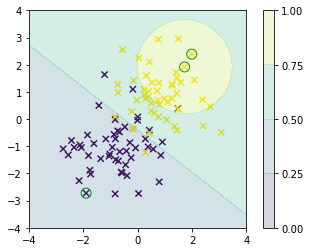

In [6]:
# 例子
def create_toy_data():
    x0 = np.random.normal(size=100).reshape(-1, 2) - 1.
    x1 = np.random.normal(size=100).reshape(-1, 2) + 1.
    x = np.concatenate([x0, x1])
    y = np.concatenate([np.zeros(50), np.ones(50)]).astype(np.int)
    return x, y

x_train, y_train = create_toy_data()

model = RelevanceVectorClassifier(RBF(np.array([1., 0.5, 0.5])))
model.fit(x_train, y_train)

x0, x1 = np.meshgrid(np.linspace(-4, 4, 100), np.linspace(-4, 4, 100))
x = np.array([x0, x1]).reshape(2, -1).T
plt.scatter(x_train[:, 0], x_train[:, 1], s=40, c=y_train, marker="x")
plt.scatter(model.X[:, 0], model.X[:, 1], s=100, facecolor="none", edgecolor="g")
plt.contourf(x0, x1, model.predict_proba(x).reshape(100, 100), np.linspace(0, 1, 5), alpha=0.2)
plt.colorbar()
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.gca().set_aspect("equal", adjustable="box")